In [1]:
import dame_flame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import LabelBinarizer

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STAR_Students = pd.read_spss('STAR_Students.sav')

In [3]:
"""Code to replicate Section 3.2 of dame-flame paper.

Note that this relies on the file Star_Students.sav. To download this file,
please see the original data on the Harvard Dataverse at this link:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/10766

Prints Figure 2 from dame-flame paper to a file with name cate-graph4.png

"""

# Data Cleaning Steps
df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gktrace', 'gkfreelunch', 
     'birthmonth', 'gksurban', 'gktgen', 'gktreadss', 'gkschid',
     'gkthighdegree', 'birthyear'])]

d = {"WHITE": 1, "BLACK": 0, "ASIAN": 1, "HISPANIC": 0, "OTHER": 0, 
     "NATIVE AMERICAN": 0}
df_trunc['race'] = df_trunc['race'].map(d)

d = {"NON-FREE LUNCH": 0, "FREE LUNCH": 1}
df_trunc['gkfreelunch'] = df_trunc['gkfreelunch'].map(d)

d = {"MALE": 1, "FEMALE": 0}
df_trunc['gender'] = df_trunc['gender'].map(d)
df_trunc['gktgen'] = df_trunc['gktgen'].map(d)

d = {"WHITE": 1, "BLACK": 0}
df_trunc['gktrace'] = df_trunc['gktrace'].map(d)

d = {"JANUARY": 0, "FEBRUARY": 1, "MARCH": 2, "APRIL": 3, "MAY": 4, 
     "JUNE": 5, "JULY": 6, "AUGUST": 7, "SEPTEMBER": 8, "OCTOBER": 9, 
     "NOVEMBER": 10, "DECEMBER": 11}
df_trunc['birthmonth'] = df_trunc['birthmonth'].map(d)

d = {1977: 0, 1978: 1, 1979: 2, 1980:3, 1981:4}
df_trunc['birthyear'] = df_trunc['birthyear'].map(d)

d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
df_trunc['gksurban'] = df_trunc['gksurban'].map(d)

d = {"BACHELORS": 0, "MASTERS": 1, "MASTERS + ": 1, "SPECIALIST": 1}
df_trunc['gkthighdegree'] = df_trunc['gkthighdegree'].map(d)

d = {"SMALL CLASS": int(1), "REGULAR CLASS": int(0), 
     "REGULAR + AIDE CLASS": int(0)}
df_trunc['ksmall'] = df_trunc['gkclasstype'].map(d)

df_trunc = df_trunc.dropna().copy()

# Create age variable counting months
df_trunc['age'] = df_trunc['birthyear']*12 + df_trunc['birthmonth']
df_trunc = df_trunc.drop(columns=['birthmonth', 'birthyear', 
                                  'gkclasstype'])
# Bin age into deciles
df_trunc['age'] = pd.qcut(df_trunc['age'], q=10, labels=False)

df_trunc = df_trunc.rename(columns={"ksmall": "treated"}) ## NOTE TO SELF -- COME BACK TO WE SHOULDNT HAVE TO DO THIS

In [4]:
# Do the matching

models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(len(random_seeds)):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=False, verbose=0, adaptive_weights='decisiontree', 
        early_stop_pe=True)
    model_dame.fit(holdout_data=holdout_df, 
                   outcome_column_name='gktreadss')
    model_dame.predict(matching_df)
    models.append(model_dame)



3004 units matched. We finished with no more treated units to match
2947 units matched. We finished with no more treated units to match
2891 units matched. We finished with no more treated units to match
2894 units matched. We finished with no more treated units to match


In [5]:
for i in range(len(models)):
    ate, var = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("Run", i, "ATE:", ate, "& Variance of ATE:", var)

Run 0 ATE: 5.998078614036495 & Variance of ATE: 1.3608548636512854
Run 1 ATE: 4.848867498485764 & Variance of ATE: 1.431203792460095
Run 2 ATE: 5.7532774126599735 & Variance of ATE: 1.4481064663464616
Run 3 ATE: 5.5627909687256585 & Variance of ATE: 1.405629905925439


In [6]:
# Generate data for plot
match_dfs = []
for i in models:
    match_dfs.append(i.input_data)

for i in range(4):
    colname = 'cates'
    match_dfs[i][colname] = dame_flame.utils.post_processing.CATE(
        models[i], match_dfs[i].index)

dame_len_groups = []
dame_cate_of_groups = []
log_cates = []

for i in range(4):

    model_dame = models[i]
    groups = list(range(len(model_dame.units_per_group)))

    dame_cate_of_group = []
    log_cate_of_group = []
    dame_len_group = []
    dame_len_treated = []
    maxcate = 0.0
    maxgroupnum = 0
    index = 0

    flame_cate_of_group = []
    flame_len_group = []
    large_groups = []
    for group in model_dame.units_per_group:
        dame_cate_of_group.append(dame_flame.utils.post_processing.CATE(
            model_dame, group[0]))
        dame_len_group.append(len(group))

        # find len of just treated units
        df_mmg = df_trunc.loc[group]
        treated = df_mmg.loc[df_mmg["treated"] == 1]

    dame_len_groups.append(dame_len_group)
    dame_cate_of_groups.append(dame_cate_of_group)



C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

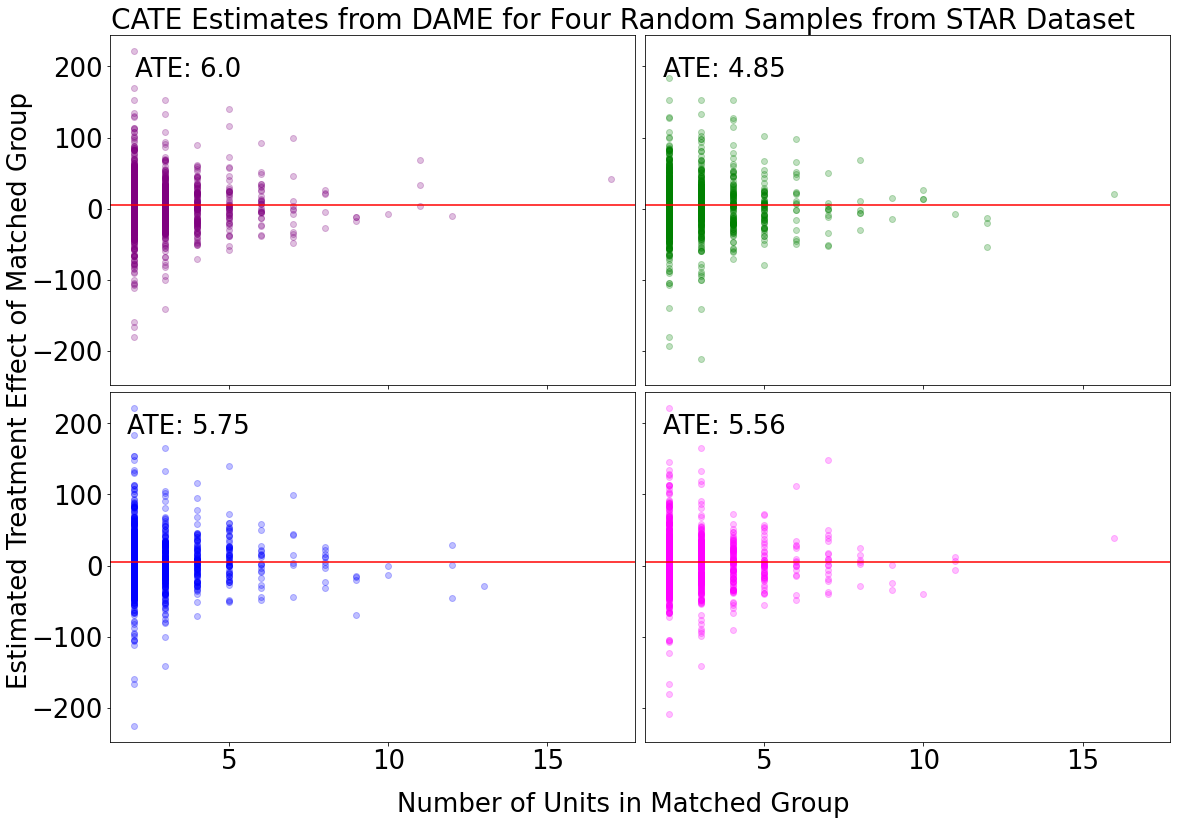

In [7]:
# Create the plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Estimated Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=ates[0], color='r', linestyle='-')
ax2.axhline(y=ates[1], color='r', linestyle='-')
ax3.axhline(y=ates[2], color='r', linestyle='-')
ax4.axhline(y=ates[3], color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

ax1.scatter(dame_len_groups[0], dame_cate_of_groups[0], color="purple", 
            alpha = 0.25)
ax1.text(0.15, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

ax2.scatter(dame_len_groups[1], dame_cate_of_groups[1], color="green", 
            alpha = 0.25)
ax2.text(0.15, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

ax3.scatter(dame_len_groups[2], dame_cate_of_groups[2], color="blue", 
            alpha = 0.25)
ax3.text(0.15, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

ax4.scatter(dame_len_groups[3], dame_cate_of_groups[3], color="magenta",
            alpha = 0.25)
ax4.text(0.15, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)


plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('cate-graph4.png', dpi = 200)

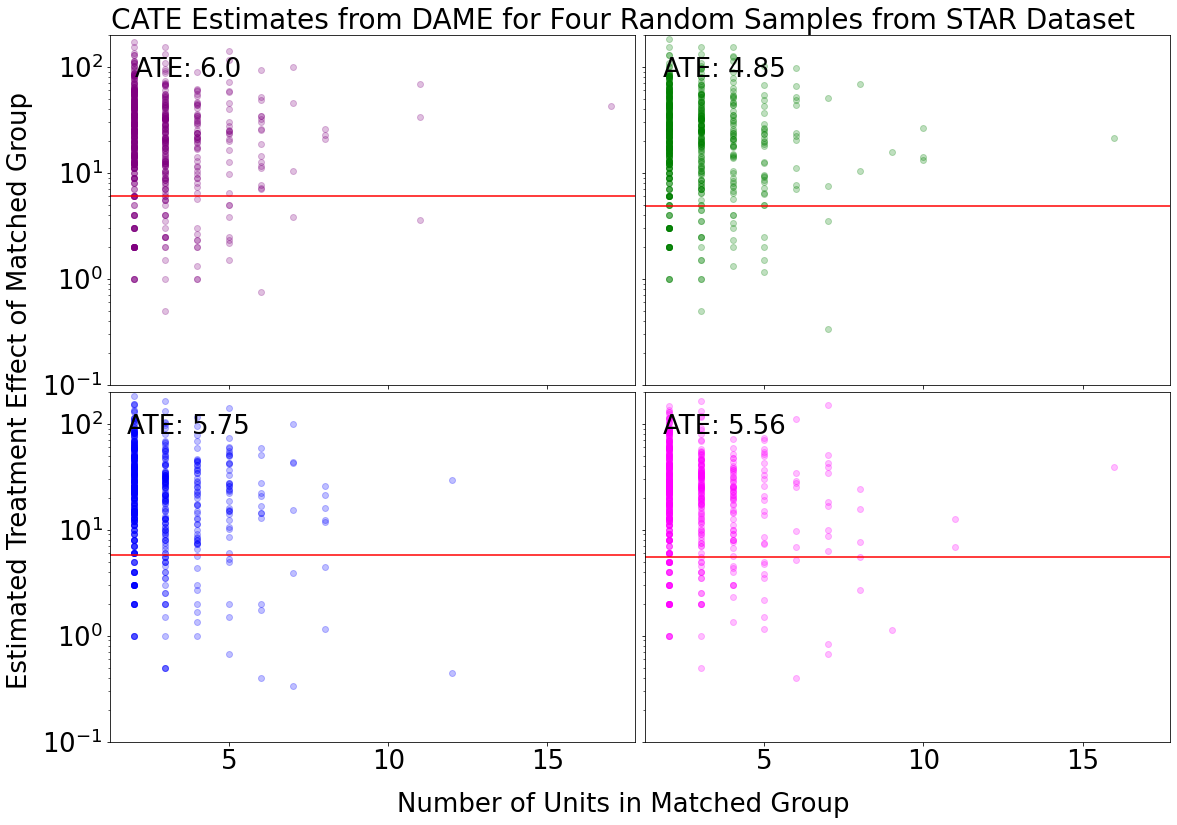

In [8]:
# Create the plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Estimated Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=ates[0], color='r', linestyle='-')
ax2.axhline(y=ates[1], color='r', linestyle='-')
ax3.axhline(y=ates[2], color='r', linestyle='-')
ax4.axhline(y=ates[3], color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

ax1.scatter(dame_len_groups[0], dame_cate_of_groups[0], color="purple", 
            alpha = 0.25)
ax1.text(0.15, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

ax2.scatter(dame_len_groups[1], dame_cate_of_groups[1], color="green", 
            alpha = 0.25)
ax2.text(0.15, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

ax3.scatter(dame_len_groups[2], dame_cate_of_groups[2], color="blue", 
            alpha = 0.25)
ax3.text(0.15, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

ax4.scatter(dame_len_groups[3], dame_cate_of_groups[3], color="magenta",
            alpha = 0.25)
ax4.text(0.15, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax1.set_ylim(0.1, 250)
ax2.set_ylim(0.1, 200)
ax3.set_ylim(0.1, 200)
ax4.set_ylim(0.1, 200)


plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('cate-graph4.png', dpi = 200)

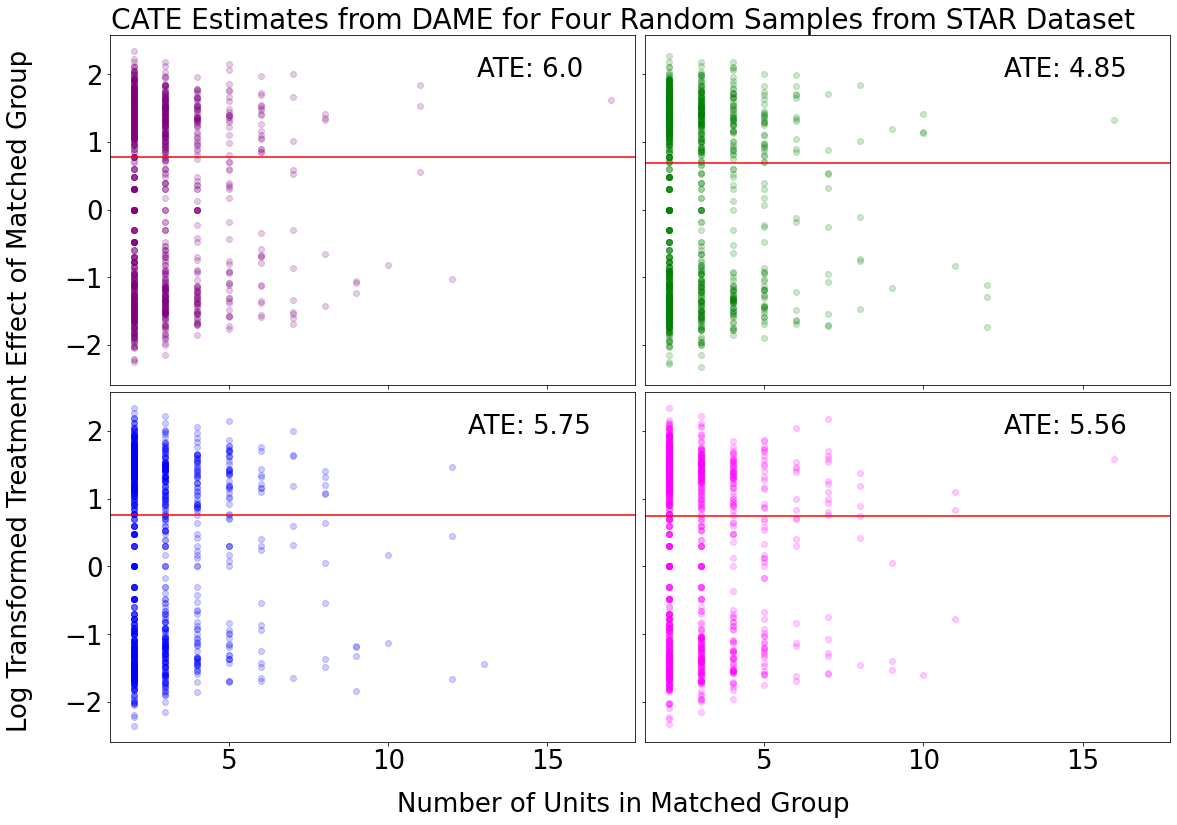

In [9]:
# Plot log scale
# Create the plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Log Transformed Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=np.log10(ates[0]), color='r', linestyle='-')
ax2.axhline(y=np.log10(ates[1]), color='r', linestyle='-')
ax3.axhline(y=np.log10(ates[2]), color='r', linestyle='-')
ax4.axhline(y=np.log10(ates[3]), color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

al=0.2

temp = np.array(dame_cate_of_groups[0])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax1.scatter(dame_len_groups[0], result, color="purple", 
            alpha = al)
ax1.text(0.8, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[1])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax2.scatter(dame_len_groups[1], result, color="green", 
            alpha = al)
ax2.text(0.8, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[2])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax3.scatter(dame_len_groups[2], result, color="blue", 
            alpha = al)
ax3.text(0.8, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[3])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax4.scatter(dame_len_groups[3], result, color="magenta",
            alpha = al)
ax4.text(0.8, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)

plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('cate-graph4.png', dpi = 200)

In [10]:
list_star_covars = []
for modelid in range(len(models)):

    # Pull out the groups with 10 or more units in the matched group
    model = models[modelid]
    large_groups = []
    for group in model.units_per_group:
        if len(group) >= 12.5:
            large_groups.append(group)

    covariates = set(models[modelid].input_data.columns) - set(['gktreadss', 'treated', 'cates'])
    # Which covars did the large group match on?
    star_covars = dict()
    for group in large_groups:
        group_star_covars = []
        matched_df = models[modelid].df_units_and_covars_matched.loc[group]
        for covar in covariates:
            if '*' in matched_df[covar].values:
                group_star_covars.append(covar)
        cate_of_group = models[modelid].input_data.loc[group[0], 'cates']
        star_covars[cate_of_group] = group_star_covars
        
    list_star_covars.append(star_covars)

In [11]:
list_star_covars

[{42.3125: ['gkschid']},
 {21.285714285714278: ['gksurban', 'gkschid']},
 {-28.0: ['gkschid']},
 {39.26666666666665: ['age', 'gktrace']}]

In [12]:
models[3].input_data.loc[large_groups[0]]

,gender,race,gkschid,gksurban,gktgen,gktrace,gkthighdegree,gkfreelunch,gktreadss,treated,age,cates
1411,0,0.0,244708.0,3,0,1,0.0,1,421.0,0.0,0,39.266667
2977,0,0.0,244708.0,3,0,1,0.0,1,442.0,0.0,0,39.266667
7652,0,0.0,244708.0,3,0,1,0.0,1,425.0,0.0,7,39.266667
3014,0,0.0,244708.0,3,0,1,0.0,1,418.0,0.0,0,39.266667
7483,0,0.0,244708.0,3,0,1,0.0,1,374.0,0.0,8,39.266667
7493,0,0.0,244708.0,3,0,1,0.0,1,414.0,0.0,2,39.266667
2478,0,0.0,244708.0,3,0,1,0.0,1,395.0,0.0,0,39.266667
1637,0,0.0,244708.0,3,0,1,0.0,1,419.0,0.0,0,39.266667
3455,0,0.0,244708.0,3,0,0,0.0,1,448.0,1.0,3,39.266667
3017,0,0.0,244708.0,3,0,1,0.0,1,416.0,0.0,1,39.266667


In [13]:
list_star_covars

[{42.3125: ['gkschid']},
 {21.285714285714278: ['gksurban', 'gkschid']},
 {-28.0: ['gkschid']},
 {39.26666666666665: ['age', 'gktrace']}]

In [14]:
## Check the matched group with the most units in each trial -- also which covariates did they use and which units in their MMG?

In [15]:
## Run DAME and FLAME and show why we chose DAME for this dataset. What happens if we run FLAME?
flame_models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_flame = dame_flame.matching.FLAME(
        repeats=False, verbose=3, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1, 
        early_stop_pe=True)
    model_flame.fit(holdout_data=holdout_df, 
                   outcome_column_name='gktreadss')
    result_flame = model_flame.predict(matching_df)
    flame_models.append(model_flame)


Iteration number:  1
	Number of matched groups formed in total:  341
	Unmatched treated units:  838 out of a total of  1263 treated units
	Unmatched control units:  2253 out of a total of  2822 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  994
	Number of matches made so far:  994
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  341
	Unmatched treated units:  838 out of a total of  1263 treated units
	Unmatched control units:  2253 out of a total of  2822 control units
	Predictive error of covariates chosen this iteration:  128.17420888589712
	Number of matches made in this iteration:  0
	Number of matches made so far:  994
	In this iteration, the covariates dropped are:  gksurban
Iteration number:  3
	Number of matched groups formed in total:  341
	Unmatched treated units:  838 out of a total of  1263 treated units
	Unmatched control units:  2253 

Iteration number:  4
	Number of matched groups formed in total:  383
	Unmatched treated units:  731 out of a total of  1205 treated units
	Unmatched control units:  2255 out of a total of  2880 control units
	Predictive error of covariates chosen this iteration:  89.63508437976523
	Number of matches made in this iteration:  145
	Number of matches made so far:  1099
	In this iteration, the covariates dropped are:  gktrace
Iteration number:  5
	Number of matched groups formed in total:  412
	Unmatched treated units:  699 out of a total of  1205 treated units
	Unmatched control units:  2220 out of a total of  2880 control units
	Predictive error of covariates chosen this iteration:  95.0192604873456
	Number of matches made in this iteration:  212
	Number of matches made so far:  1166
	In this iteration, the covariates dropped are:  race
Iteration number:  6
	Number of matched groups formed in total:  640
	Unmatched treated units:  428 out of a total of  1205 treated units
	Unmatched contr

In [16]:
# whats the var of the ates?
for model in flame_models:
    print(dame_flame.utils.post_processing.var_ATE(matching_object=model))

(5.232040471737027, 1.6267213145145099)
(5.496811836291416, 1.725244714261442)
(6.212410901454291, 1.735774248059574)
(6.171045780100664, 1.555232418593294)
